# Proyecto Expansión del Universo
## Lizeth Daniela Jaimes González


En los primeros momentos de la Cosmología moderna no se creı́a en la existencia de la energía oscura, y la pregunta más importante era si la cantidad de materia serı́a suficiente para frenar la expansión. El caso límite se da cuando el Universo es plano con $\Omega_M$= 1, y el Universo se expande cada vez más lentamente, pero sin detenerse. Universos con $\Omega_M$ > 1 serán cerrados, volviendo a colapsar sobre sı́ mismos por acción de la gravedad, mientras que Universos con $\Omega_M$ < 1 serán abiertos y se expandirán para siempre de forma acelerada.

In [1]:
#Inicialmente se importaron todas las librerias que necesitamos
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from astropy import constants as ct
from astropy import units as unit
#from astropy.cosmology import Plank13 as cosmo
import seaborn as sns
import pandas as pd
import copy
import functools

La evolución de un Universo homogéneo e isotrópico en expansión se puede
estudiar de forma analı́tica a través de las ecuaciones de Fiedmann-Lemaitre, las cuales
surgen naturalmente de las ecuaciones de Einstein de la relatividad general, la mejor des-
cripción que poseemos para explicar la interacción entre el tiempo, el espacio y la fuerza
de la gravedad. Dichas ecuaciones permiten predecir, por ejemplo, la relación exacta entre
la distancia luminosidad (en Mpc) y el corrimiento al rojo según la cantidad de materia y
energı́a existentes en el Universo:

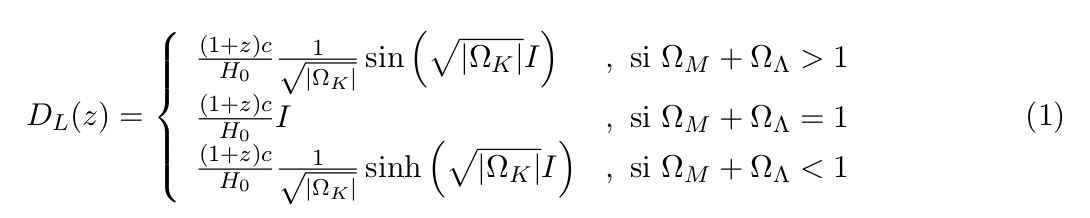

$\Omega_M$ representa el porcentaje de la energı́a del Universo que
está compuesto por materia; $\Omega_\Lambda$ representa el porcentaje de la energı́a del Universo en forma
de energı́a oscura, la misteriosa quintaesencia que proporciona la “gravedad negativa” para
que el universo se expanda; finalmente $\Omega_K$ representa la curvatura del Universo: si es igual
a 0 quiere decir que el Universo es plano, y mayor/menor a 0 corresponde con modelos de
Universo abierto/cerrado, respectivamente. Aunque hay algunas componentes adicionales
(radiación, neutrinos), estas 3 son las que dominan el comportamiento de la expansión, y se
relacionan mediante $\Omega_M+\Omega_\Lambda+\Omega_k$ = 1.

In [2]:
# Se utilizan las constantes c y Ho a tráves de las librerías astropy, y se definen los valores de omega 
# mencionados anteriormente

c = (ct.c).to(unit.km / unit.s)
#Ho = cosmo.H(0).value
Ho = 73.5 * unit.km / unit.s / unit.Mpc
#c = 300000 #km/s
#Ho = 73.5 #km/(s*Mpc)
omega_m = 0.28
omega_v = 0.72
omega = omega_m + omega_v 
omega_k = 1 - omega
omega_r = np.sqrt(np.abs(omega_k))

En cuanto a la variable I, esta resulta de integrar
los diferenciales de distancia recorridos por la luz en función del corrimiento al rojo, desde
el momento en que fue emitida hasta hoy (z = 0), y está dada por:
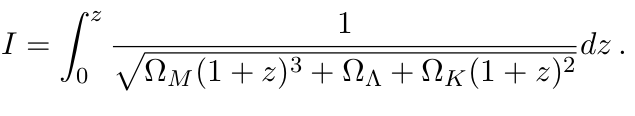

In [3]:
#Se define la anterior integral por medio de la función 'quad' importada de 'scipy.integrate'
def Int(z):
    raiz = np.sqrt(omega_m*(1+z)**3 + omega_v + omega_k*(1+z)**2)
    I = integrate.quad(lambda z: 1/(raiz), 0, z)[0]
    return I

Se define el módulo de la distancia de luminosidad como:
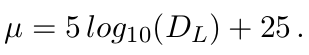

In [32]:
#Luego, a partir de la definición de 'I', se define la ec.(1), por medio de un 'if' para analizar los 3 casos
def lum(z, omega_m, omega_v):
    I = Int(z)
    omega = omega_m + omega_v 
    omega_k = 1 - omega
    omega_r = np.sqrt(np.abs(omega_k))
    if omega>1:
        d_l = (1 + z)*c*np.sin(omega_r*I)/(Ho*omega_r)
    elif omega==1:
        d_l = (1 + z)*c*I/Ho
    else:
        d_l = (1 + z)*c*np.sinh(omega_r*I)/(Ho*omega_r) 
    d_l = 5*np.log10(d_l.value)+25.3 #Esto es para definir el módulo de la distancia de luminosidad
    return d_l

In [33]:
#Se crea el rango que va recorrer la variable 'z' para proceder a graficar el módulo de la distancia vs
# el corrimiento al rojo en el caso omega_m = 0.28, omega_v = 0.72
zz = np.arange(0, 1, 0.02)
dls = []
for i in zz:
    res = lum(z=i, omega_m = 0.28, omega_v = 0.72)
    dls.append(res)

<ipython-input-32-c080a2a7d0fa>:13: RuntimeWarning: divide by zero encountered in log10
  d_l = 5*np.log10(d_l.value)+25.3 #Esto es para definir el módulo de la distancia de luminosidad


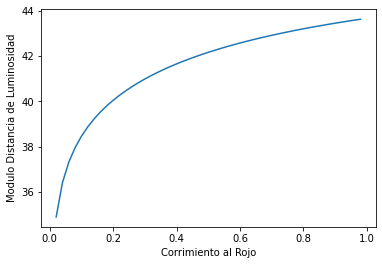

In [34]:
plt.plot(zz, dls)
plt.ylabel('Modulo Distancia de Luminosidad')
plt.xlabel('Corrimiento al Rojo')
plt.show()

In [35]:
#Ahora, con la ayuda de pandas se lee el archivo 'luminosidad.txt', el cual fue descargado de: 
# https://supernova.lbl.gov/Union/
df = pd.read_csv('luminosidad.txt', error_bad_lines=False, delim_whitespace = True, header = None)
df.columns = ['nombres', 'z', 'lumin', 'lum_error', 'error']
df = df.sort_values('z')
df['mod1'] = df['z'].apply(lambda x: lum(x, omega_m = 0.28, omega_v = 0.72))

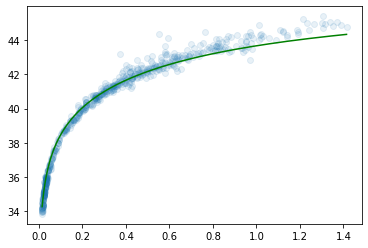

In [44]:
#Se grafica el anterior resultado junto con los datos del archivo 'luminosidad.txt' para comparar más claramente
plt.scatter(df['z'], df['lumin'], alpha = 0.1)
#plt.errorbar(df['z'], df['lumin'], yerr = df['error'], linestyle=None, alpha = 0.4, c='gray')
plt.plot(df['z'], df['mod1'], c='g')

Imagen que presenta varias similitudes con la presentada en el SUPERNOVA COSMOLOGY PROJECT
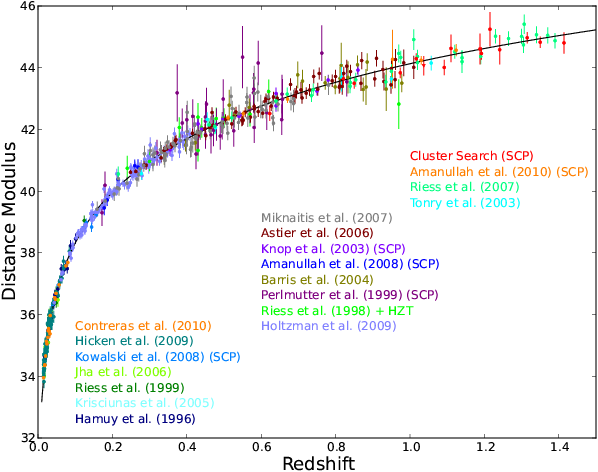

In [37]:
#Con el fin de comparar diferentes modelos, se crea una función con los parámetros que van a variar en cada uno
#de ellos, que en este caso son omega_m y omega_v 
def parametros(df, nombres, modelos):
    df_m = df.copy()
    parametros_dic = modelos[nombres]
    omega_m, omega_v = parametros_dic['omega_m'], parametros_dic['omega_v']
    df_m[nombres] = df_m['z'].apply(lambda x: lum(x, omega_m = omega_m, omega_v = omega_v)) 
    return df_m

In [38]:
#Se crea el diccionario que contiene los parametros de los diferentes modelos a comparar
mod   = {'mod1' : {'omega_m': 0.28, 'omega_v':0.72},
           'mod2' : {'omega_m': 0.1, 'omega_v':0.9},
           'mod3' : {'omega_m': 0.5, 'omega_v':0.2},
           'mod4' : {'omega_m': 0.5, 'omega_v':0.1}
          }

In [39]:
#Se crea una función calcula el error cuadrático con el cual se compararán los distintos modelos 
pun = {}
for i in mod.keys():
    df = parametros(df, nombres=i, modelos=mod)
    pun[i] = {}
    errorc = np.sum((df[i]-df['lumin'])**2/df['lum_error']**2)/len(df)
    pun[i]['errorc'] = errorc
pun = pd.DataFrame(pun)
#display(df)
display(pun)

,mod1,mod2,mod3,mod4
errorc,2.006872,2.006872,1.917223,1.889787


<AxesSubplot:xlabel='z', ylabel='value'>

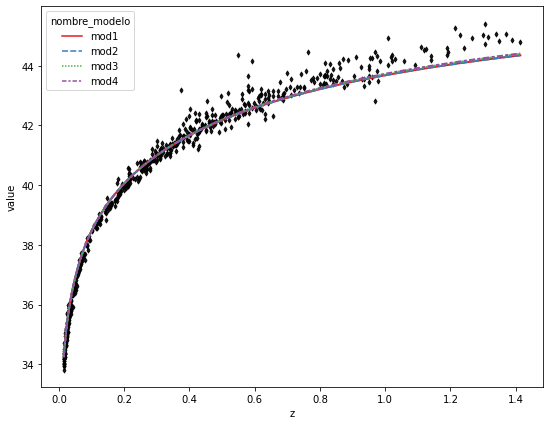

In [42]:
#Se grafican los modelos 
df2 =df.copy()
df2=pd.melt(df2, id_vars = ['nombres', 'z', 'lumin', 'lum_error', 'error'], var_name = 'nombre_modelo', value_name = 'value')

plt.figure(figsize = (9,7))
plt.scatter(df['z'], df['lumin'], alpha = 0.9, marker='d', s=12, c='k')
#plt.errorbar(df['z'], df['lumin'], yerr = df['error'], linestyle=None, alpha = 0.4, c='gray')
sns.lineplot(data=df2, x='z', y='value', hue='nombre_modelo', palette='Set1', style='nombre_modelo', linewidth=2)